#### This notebook is to directly compare LCs (and transits) between NEMESIS, QLP, TGLC and SPOC photometry

#### Helper function to download and standardize outputs from various TESS High Level Science Product pipelines

In [1]:
from typing import Any, Optional, Tuple, Union
import os
import re

import numpy as np
import pandas as pd
import astropy.units as u
from astropy.io import fits
import lksearch as lk

from typing import Dict, Iterable, Optional, Sequence, Tuple
import matplotlib.pyplot as plt

In [2]:
import TESS_pipeline
from TESS_pipeline import get_tess_LC

In [3]:
ID=259377017
Sector = 3

r, lc, newlc = get_tess_LC(
    TIC_ID=ID,
    radius=21,          # arcsec
    exptime=1800,
    Sector=Sector,
    pipeline="TESS-SPOC",   # example; replace with what you use
)

Search radius 21.0 units not specified, assuming arcsec


Selected product row:
  target_name   pipeline mission  sector  exptime  distance  year description
0   259377017  TESS-SPOC    HLSP       3   1800.0       0.0  2018        FITS


In [4]:
print(r,'\n')         # should say "TESSSearch object containing 1 data products"
print(lc.columns[:10],'\n')
print(lc.head())

TESSSearch object containing 1 data products 
  target_name   pipeline mission  sector  exptime  distance  year description
0   259377017  TESS-SPOC    HLSP       3   1800.0       0.0  2018        FITS 

Index(['TIME', 'TIMECORR', 'CADENCENO', 'SAP_FLUX', 'SAP_FLUX_ERR', 'SAP_BKG',
       'SAP_BKG_ERR', 'PDCSAP_FLUX', 'PDCSAP_FLUX_ERR', 'QUALITY'],
      dtype='object') 

          TIME  TIMECORR  CADENCENO     SAP_FLUX  SAP_FLUX_ERR      SAP_BKG  \
0  1382.053907  0.001262       7420  8348.148438      2.907079  1366.653320   
1  1382.074741  0.001262       7421  8342.750000      2.899137  1329.218140   
2  1382.095574  0.001263       7422  8351.673828      2.895285  1302.328369   
3  1382.116408  0.001263       7423  8350.665039      2.890686  1280.227417   
4  1382.137242  0.001264       7424  8348.654297      2.885473  1256.456665   

   SAP_BKG_ERR  PDCSAP_FLUX  PDCSAP_FLUX_ERR  QUALITY  PSF_CENTR1  \
0     0.871324          NaN              NaN      136         NaN   
1     0.8631

In [5]:
newlc.head(1)

,Time,Raw Flux,Raw Flux Error,BKG Flux,BKG Flux Error,Corrected Flux,Corrected Flux Error,Quality
0,1382.053907,8348.148438,2.907079,1366.65332,0.871324,NaN,NaN,136


In [6]:
from all_pipelines import get_all_pipelines

In [12]:
pipelines = ['TGLC','QLP','TESS-SPOC','GSFC-ELEANOR-LITE']

results = {}
masked_results = {}

for P in pipelines:
    r, LC, newLC = get_tess_LC(
        TIC_ID=ID,
        radius=3*21*u.arcsec,
        exptime=1800,
        Sector=3, # change later
        pipeline=P
    )

    results[P] = {"r": r, "LC": LC, "newLC": newLC}
    masked_results[P] = newLC[newLC["Quality"] == 0].copy()

Selected product row:
  target_name pipeline mission  sector  exptime  distance  year description
0   259377017     TGLC    HLSP       3   1800.0   0.60232  2018        FITS
Selected product row:
  target_name pipeline mission  sector  exptime  distance  year description
0   259377017      QLP    HLSP       3   1800.0       0.0  2018        FITS
Selected product row:
  target_name   pipeline mission  sector  exptime  distance  year description
0   259377017  TESS-SPOC    HLSP       3   1800.0       0.0  2018        FITS
Selected product row:
  target_name           pipeline mission  sector  exptime  distance  year  \
0   259377017  GSFC-ELEANOR-LITE    HLSP       3   1800.0       0.0  2018   

  description  
0        FITS  


In [31]:
results['results']['TGLC'].keys()

dict_keys(['r', 'LC', 'newLC'])

In [33]:
newLC = results['results'][P]['newLC']

In [8]:
from get_colors import _get_colors
pipeline_colors = _get_colors(len(pipelines))
pipeline_colors

[(0.9657087253015141, 0.11902355169573331, 0.11902355169573331),
 (0.5044329468126725, 0.9599781416369202, 0.048887751988424544),
 (0.17563551367345365, 0.9860932342734456, 0.9860932342734458),
 (0.5642628407565606, 0.14298406983803935, 0.9855416116750826)]

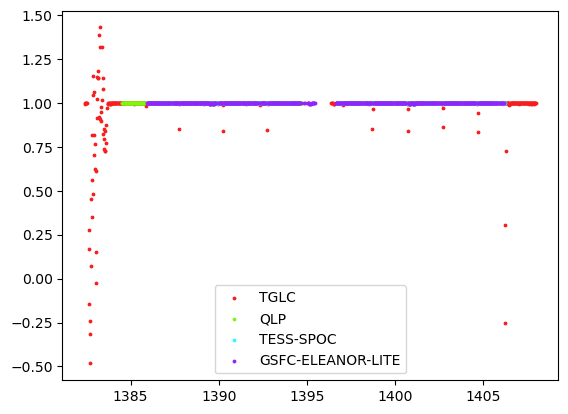

In [13]:
for pp in range(len(pipelines)):
    P = pipelines[pp]
    C = pipeline_colors[pp]

    lc_m = masked_results[P]
    plt.scatter(
        lc_m["Time"],
        lc_m["Corrected Flux"] / np.nanmedian(lc_m["Corrected Flux"]),
        s=3, label=P, color=C
    )

plt.legend(loc="best")
plt.show()

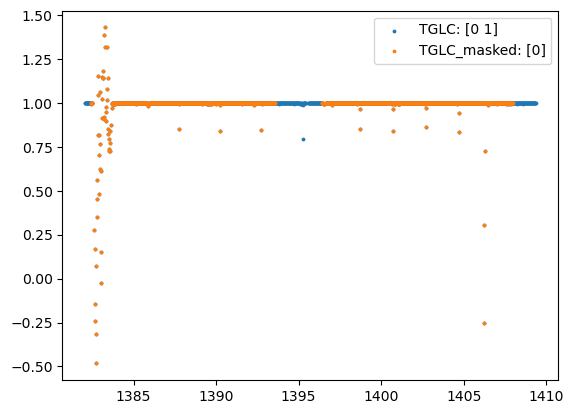

In [15]:
P = "TGLC"
lc_all = results[P]["newLC"]
lc_mask = masked_results[P]

plt.scatter(lc_all["Time"],
            lc_all["Corrected Flux"] / np.nanmedian(lc_all["Corrected Flux"]),
            s=3, label=f"{P}: {np.unique(lc_all['Quality'])}")

plt.scatter(lc_mask["Time"],
            lc_mask["Corrected Flux"] / np.nanmedian(lc_mask["Corrected Flux"]),
            s=3, label=f"{P}_masked: {np.unique(lc_mask['Quality'])}")

plt.legend(loc="best")
plt.show()

# get ```nearby_TOI_MDs.csv```

In [16]:
nearby_TOI_MD_df=pd.read_csv('/Users/madelinejmg/Desktop/PHYS39002/project2026/catalog/nearby_TOI_MDs.csv')
nearby_TOI_MD_df.head(5)

,Unnamed: 0,Parameter Source Pipeline,Detection Pipeline(s),TIC ID,Full TOI ID,TOI Disposition,TIC Right Ascension,TIC Declination,TIC Right Ascension 2015.5,TIC Declination 2015.5,TMag Value,TMag Uncertainty,Orbital Epoch Value,Epoch Uncertainty,Orbital Period (days) Value,Orbital Period Uncertainty,Transit Duration (hours) Value,Transit Duration (hours) Uncertainty,Transit Depth Value,Transit Depth Uncertainty,Sectors,Public Comment,Surface Gravity Value,Surface Gravity Uncertainty,Planet Number,Star Radius Value,Star Radius Uncertainty,Planet Radius Value,Planet Radius Uncertainty,Planet Equilibrium Temperature (K) Value,Effective Temperature Value,Effective Temperature Uncertainty,Effective Stellar Flux Value,Signal-to-noise,Centroid Offset,Master,SG1a,SG1b,SG2,SG3,SG4,SG5,Alerted,Updated,ID,ra,dec,pmRA,pmDEC,Tmag,objType,typeSrc,version,HIP,TYC,UCAC,TWOMASS,SDSS,ALLWISE,GAIA,APASS,KIC,POSflag,e_pmRA,e_pmDEC,PMflag,plx,e_plx,PARflag,gallong,gallat,eclong,eclat,Bmag,e_Bmag,Vmag,e_Vmag,umag,e_umag,gmag,e_gmag,rmag,e_rmag,imag,e_imag,zmag,e_zmag,Jmag,e_Jmag,Hmag,e_Hmag,Kmag,e_Kmag,TWOMflag,prox,w1mag,e_w1mag,w2mag,e_w2mag,w3mag,e_w3mag,w4mag,e_w4mag,GAIAmag,e_GAIAmag,e_Tmag,TESSflag,SPFlag,Teff,e_Teff,logg,e_logg,MH,e_MH,rad,e_rad,mass,e_mass,rho,e_rho,lumclass,lum,e_lum,d,e_d,ebv,e_ebv,numcont,contratio,disposition,duplicate_id,priority,eneg_EBV,epos_EBV,EBVflag,eneg_Mass,epos_Mass,eneg_Rad,epos_Rad,eneg_rho,epos_rho,eneg_logg,epos_logg,eneg_lum,epos_lum,eneg_dist,epos_dist,distflag,eneg_Teff,epos_Teff,TeffFlag,gaiabp,e_gaiabp,gaiarp,e_gaiarp,gaiaqflag,starchareFlag,VmagFlag,BmagFlag,splists,e_RA,e_Dec,RA_orig,Dec_orig,e_RA_orig,e_Dec_orig,raddflag,wdflag,dstArcSec,qld_a,qld_b,i,M_planet [ME],K_RV [m/s],TSM,ESM,Stellar Insolation [ergs/cm^2/s],Stellar Insolation [Earth Units],Sectors_Observed,Cameras,CCDs,EdgeWarn
0,0,spoc-s01-s36-b0A-CPKP,SPOC,410153553,136.01,PC,340.492100,-69.169000,340.496204,-69.172108,11.877,0.064,1325.724661,0.000156,0.462931,3.872269e-06,0.631015,0.022202,4677.673602,171.681260,"1,27,28,67,68,94,95,101,102,103,104",LHS 3844 b,5.09707,0.426694,1,0.188624,0.005710,1.517197,0.061800,723.372047,3043.0,63.0,64.709477,38.885654,False,5,5,5,5,5,5,5,2018-09-05 18:51:57+00:00,2020-10-27 13:01:47.547000+00:00,410153553,340.492156,-69.168978,334.3570,-726.9740,11.92380,STAR,tmgaia2,20190415,NaN,NaN,105-116381,22415815-6910089,NaN,NaN,6385548541499112448,33464847.0,NaN,tmgaia2,0.082820,0.086335,gaia2,67.15480,0.050599,gaia2,318.253844,-43.907555,304.887051,-54.122569,16.942,0.041,15.240,0.032,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10.046,0.023,9.477,0.023,9.145,0.023,AAA-222-111-000-0-0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,13.3925,0.000738,0.007698,cdwrf,cdwrf,3004.0,157.0,5.08528,0.029186,NaN,NaN,0.188624,0.005710,0.157909,0.020067,23.52970,0.863072,DWARF,0.002610,0.000708,14.8846,0.0113,0.000000,0.000000,81.0,0.010833,NaN,NaN,0.009687,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0113,0.0113,bj2018,NaN,NaN,cdwrf,15.4512,0.007263,12.05170,0.002827,1,NaN,cdwrf,apassdr9,cooldwarfs_v8,1.559812,1.338867,340.496204,-69.172108,0.041207,0.042399,1,0,0.0,0.1933,0.5347,1.570796,2.913518,8.243782,328.631928,NaN,8.866874e+07,64.915025,11.0,"3,3,3,2,2,2,2,4,4,3,3","2,1,2,2,1,2,1,3,2,3,2","0,0,0,0,0,0,0,0,0,0,0"
1,1,spoc-s01-s69-b0A-CP,SPOC/QLP,234994474,134.01,CP,350.031300,-60.065200,350.028592,-60.065729,9.169,0.019,1326.034032,0.000566,1.401518,4.810232e-06,1.158306,0.325507,593.754092,42.808456,"1,28,68,95,102,104,105",L 168-9 b,4.67812,0.063226,1,0.597007,0.018150,1.461685,1.838503,891.638989,3794.0,69.0,149.374754,20.450527,False,5,5,5,5,5,5,5,2018-09-05 18:51:57+00:00,2024-09-30 23:32:46.016000+00:00,234994474,350.031352,-60.065179,-319.9610,-127.7810,9.22978,STAR,tmgaia2,20190415,115211.0,9126-00748-1,150-224713,23200751-6003545,NaN,NaN,6491962296196145664,31785853.0,NaN,tmgaia2,0.102122,0.115073,gaia2,39.73310,0.037526,gaia2,321.954596,-53.560374,319.217901,-49.527946,12.460,0.025,11.005,0.018,Na

# grab a TOI by name and extract LCs

In [17]:
from toi_extraction import extract_tois_lcs

In [18]:
results = extract_tois_lcs(
    nearby_TOI_MD_df,
    radius_arcsec=21,
    exptime=1800,
    verbose=True
)

Search radius 21.0 units not specified, assuming arcsec


0.5682596 2226.7836315 0.755 0.04254 52280468 6
Trying to get TGLC LC for TIC 52280468 in Sector 6
Selected product row:
  target_name pipeline mission  sector  exptime  distance  year description
0    52280468     TGLC    HLSP       6   1800.0       0.0  2018        FITS


Search radius 21.0 units not specified, assuming arcsec


Trying to get QLP LC for TIC 52280468 in Sector 6
Selected product row:
  target_name pipeline mission  sector  exptime  distance  year description
0    52280468      QLP    HLSP       6   1800.0       0.0  2018        FITS


Search radius 21.0 units not specified, assuming arcsec


Trying to get TESS-SPOC LC for TIC 52280468 in Sector 6
Selected product row:
  target_name   pipeline mission  sector  exptime  distance  year description
0    52280468  TESS-SPOC    HLSP       6   1800.0       0.0  2018        FITS


Search radius 21.0 units not specified, assuming arcsec


Trying to get GSFC-ELEANOR-LITE LC for TIC 52280468 in Sector 6
Selected product row:
  target_name           pipeline mission  sector  exptime  distance  year  \
0    52280468  GSFC-ELEANOR-LITE    HLSP       6   1800.0       0.0  2018   

  description  
0        FITS  


In [20]:
target = results["target"]
target

,Unnamed: 0,Parameter Source Pipeline,Detection Pipeline(s),TIC ID,Full TOI ID,TOI Disposition,TIC Right Ascension,TIC Declination,TIC Right Ascension 2015.5,TIC Declination 2015.5,TMag Value,TMag Uncertainty,Orbital Epoch Value,Epoch Uncertainty,Orbital Period (days) Value,Orbital Period Uncertainty,Transit Duration (hours) Value,Transit Duration (hours) Uncertainty,Transit Depth Value,Transit Depth Uncertainty,Sectors,Public Comment,Surface Gravity Value,Surface Gravity Uncertainty,Planet Number,Star Radius Value,Star Radius Uncertainty,Planet Radius Value,Planet Radius Uncertainty,Planet Equilibrium Temperature (K) Value,Effective Temperature Value,Effective Temperature Uncertainty,Effective Stellar Flux Value,Signal-to-noise,Centroid Offset,Master,SG1a,SG1b,SG2,SG3,SG4,SG5,Alerted,Updated,ID,ra,dec,pmRA,pmDEC,Tmag,objType,typeSrc,version,HIP,TYC,UCAC,TWOMASS,SDSS,ALLWISE,GAIA,APASS,KIC,POSflag,e_pmRA,e_pmDEC,PMflag,plx,e_plx,PARflag,gallong,gallat,eclong,eclat,Bmag,e_Bmag,Vmag,e_Vmag,umag,e_umag,gmag,e_gmag,rmag,e_rmag,imag,e_imag,zmag,e_zmag,Jmag,e_Jmag,Hmag,e_Hmag,Kmag,e_Kmag,TWOMflag,prox,w1mag,e_w1mag,w2mag,e_w2mag,w3mag,e_w3mag,w4mag,e_w4mag,GAIAmag,e_GAIAmag,e_Tmag,TESSflag,SPFlag,Teff,e_Teff,logg,e_logg,MH,e_MH,rad,e_rad,mass,e_mass,rho,e_rho,lumclass,lum,e_lum,d,e_d,ebv,e_ebv,numcont,contratio,disposition,duplicate_id,priority,eneg_EBV,epos_EBV,EBVflag,eneg_Mass,epos_Mass,eneg_Rad,epos_Rad,eneg_rho,epos_rho,eneg_logg,epos_logg,eneg_lum,epos_lum,eneg_dist,epos_dist,distflag,eneg_Teff,epos_Teff,TeffFlag,gaiabp,e_gaiabp,gaiarp,e_gaiarp,gaiaqflag,starchareFlag,VmagFlag,BmagFlag,splists,e_RA,e_Dec,RA_orig,Dec_orig,e_RA_orig,e_Dec_orig,raddflag,wdflag,dstArcSec,qld_a,qld_b,i,M_planet [ME],K_RV [m/s],TSM,ESM,Stellar Insolation [ergs/cm^2/s],Stellar Insolation [Earth Units],Sectors_Observed,Cameras,CCDs,EdgeWarn
0,37,qlp-s33-tois,SPOC/QLP,52280468,472.01,PC,99.866803,-33.540286,99.86703,-33.540223,12.29,0.018,2226.783631,0.001587,0.56826,0.000001,0.755,0.0,42540.0,0.841172,"6,7,33,87",no GAIA radius with Teff 3869K; large planet around an M star if real,4.438,0.0,1,0.5,0.02,24.8489,0.784699,954.0,3294.0,0.0,138.045,136.0,False,3,4,3,3,4,4,4,2019-02-22 14:51:22+00:00,2022-07-11 15:22:52.380000+00:00,52280468,99.866797,-33.540303,45.0688,18.4182,12.3123,STAR,tmgaia2,20190415,NaN,NaN,283-012187,06392802-3332250,NaN,J063928.06-333224.9,5583372517465364352,15238628.0,NaN,tmgaia2,3.7386,3.7386,hsoy,NaN,NaN,NaN,242.482472,-16.898076,104.984157,-56.467485,16.356,0.028,15.002,0.172,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10.766,0.026,10.177,0.022,9.918,0.021,AAA-222-111-000-0-0,NaN,9.781,0.023,9.618,0.021,9.458,0.035,8.436,NaN,13.5596,0.000548,0.007333,cdwrf,cdwrf,3364.0,157.0,4.73521,0.009199,NaN,NaN,0.502513,0.015836,0.500534,0.020942,3.9445,0.208119,DWARF,0.029135,0.007316,NaN,NaN,NaN,NaN,190.0,0.021652,NaN,NaN,0.001818,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,cdwrf,15.01,0.003275,12.3799,0.001348,0,NaN,ucac4,apassdr9,cooldwarfs_v8,60.525435,57.948566,99.86703,-33.540223,0.15753,0.175565,1,0,0.0,0.1819,0.4364,1.570796,65877.461212,80677.213069,8.301612,NaN,3.489554e+08,255.47277,4.0,"3,3,3,3","1,2,1,1","0,0,0,0"


In [21]:
from phasefold import phasefold, plot_phasefolded

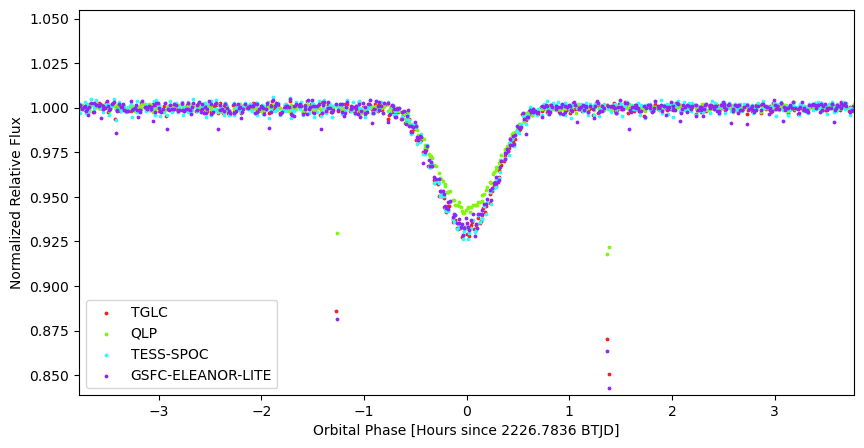

In [34]:
fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(111)

all_ymins, all_ymaxs = [], []

for pp in range(len(pipelines)):
    P = pipelines[pp]
    C = pipeline_colors[pp]

    lc_key = f"{P}_newLC_masked" if f"{P}_newLC_masked" in globals() else f"{P}_newLC"
    lc = results['results'][P]['newLC']

    ymin, ymax = plot_phasefolded(ax=ax, target=target, lc=lc, color=C, label=f"{P}")
    all_ymins.append(ymin)
    all_ymaxs.append(ymax)

ax.set_ylim(np.nanmedian(all_ymins), np.nanmedian(all_ymaxs))

t0 = target["Orbital Epoch Value"].item()
ax.set_xlabel(f"Orbital Phase [Hours since {np.round(t0, 4)} BTJD]")
ax.set_ylabel("Normalized Relative Flux")
ax.legend(loc="best", fontsize=10)
plt.show()

# Note that for the largest planet in nearby M-dwarfs, the depths are different (likely due to data processing differences in pipelines)